# Generate symbols from fonts

## Imports

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont

import os
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset


Matplotlib created a temporary cache directory at /tmp/matplotlib-m6vdiewf because the default path (/teamspace/studios/this_studio/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
def generate_symbol(symbol, font_path, ratio=0.8, image_size=(28, 28)):
    INITIAL_IMAGE_SIZE = (1000, 1000)
    font = ImageFont.truetype(font_path, size=INITIAL_IMAGE_SIZE[0] // 3)
    image = Image.new("RGB", INITIAL_IMAGE_SIZE, color="black")
    draw = ImageDraw.Draw(image)
    bbox = draw.textbbox((0, 0), symbol, font=font)
    text_width, text_height = bbox[2] - bbox[0], bbox[3] - bbox[1]
    position = ((INITIAL_IMAGE_SIZE[0] - text_width) // 2, (INITIAL_IMAGE_SIZE[1] - text_height) // 2)
    draw.text(position, symbol, fill="white", font=font, anchor='lt')

    # centering image
    side_len = max(text_height, text_width)
    indent = int(side_len * (1 - ratio) / ratio) // 2
    diff = max(text_height, text_width) - min(text_height, text_width)
    largest_side = "height" if text_height == side_len else "width"
    if largest_side == "height":
        x, y = position[0] - indent - diff // 2, position[1] - indent
    else:
        x, y = position[0] - indent, position[1] - indent - diff // 2
    square_box = (x, y, x + side_len + 2 * indent, y + side_len + 2 * indent)
    # draw.rectangle(square_box, outline='blue')
    image = image.crop(square_box)
    image = image.resize(image_size)
    return image
    

In [3]:
def print_image(image, symbol):
    fig, ax = plt.subplots(figsize=(4, 8))

    ax.imshow(image, cmap='gray')
    ax.set_title(symbol)
    # ax.axis('off')  # Hide axes

    plt.tight_layout()
    plt.show()

In [4]:
def save_image(image, path):
    image.save(path)

In [5]:
def generate_font_characters(font_dir, output_dir, symbols, ratio=0.8, image_size=(28, 28)):
    dataset = pd.DataFrame(columns=['path', 'label'])
    os.makedirs(output_dir, exist_ok=True)
    for font in os.listdir(font_dir):
        font_path = os.path.join(font_dir, font)
        for symbol in symbols:
            image = generate_symbol(symbol, font_path, ratio=ratio, image_size=image_size)
            # print_image(image, symbol)
            save_image(image, f"{output_dir}/{symbol} ({font.split('.')[0]}).png")
            dataset.loc[len(dataset)] = [f"{output_dir}/{symbol} ({font.split('.')[0]}).png", symbol]

    return dataset

In [10]:
# symbols = "ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz0123456789"
symbols = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabdefghnqrt'
# symbols = "A"
dataset = generate_font_characters("data/fonts/fonts_files", "data/fonts/fonts_characters", symbols)
dataset.head()

,path,label
0,data/fonts/fonts_characters/0 (Affectionately ...,0
1,data/fonts/fonts_characters/1 (Affectionately ...,1
2,data/fonts/fonts_characters/2 (Affectionately ...,2
3,data/fonts/fonts_characters/3 (Affectionately ...,3
4,data/fonts/fonts_characters/4 (Affectionately ...,4


In [11]:
dataset.to_csv("data/fonts/dataset.csv", index=False)

In [21]:
class FontDataset:
    def __init__(self, dataset_path, mapping_path, transform=None, limit=None):
        self.path = dataset_path
        self.dataset = pd.read_csv(self.path)
        self.transform = transform
        with open(mapping_path, "r") as f:
            lines = f.read().split("\n")[:-1]
            self.mapping = {}
            self.unmapping = {}
            for line in lines:
                char_class, char_code = line.split()
                self.mapping[int(char_class)] = chr(int(char_code))
                self.unmapping[chr(int(char_code))] = int(char_class)
        if limit:
            self.dataset = dataset.sample(limit)

    def __getitem__(self, idx):
        if isinstance(idx, slice):
            images_path = self.dataset.iloc[idx]["path"]
            images = [Image.open(path) for path in images_path]
            if self.transform:
                images = torch.stack([self.transform(img) for img in images])  # Apply transform per image
                # images = images.unsqueeze(1)  # Add channel dimension: [Batch, 1, 28, 28]

            labels = [self.unmapping[label] for label in self.dataset.iloc[idx]["label"]]
            labels = torch.tensor(labels, dtype=torch.long)
            return images, labels

        else:
            image_path = self.dataset.iloc[idx]["path"]
            image = Image.open(image_path)
            if self.transform:
                image = self.transform(image)
                # image = image.unsqueeze(0) 
                # print_tensor_stats(image, "Transformed Image")

            label = self.unmapping[self.dataset.iloc[idx]["label"]]
            label = torch.tensor(label, dtype=torch.long)
            return image, label

In [12]:
font_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Grayscale(1),
        transforms.Normalize(mean=(0.5,), std=(0.5,)),  # Normalize to [-1, 1]
    ])

In [22]:
df = FontDataset("data/fonts/dataset.csv", "data/fonts/mapping.txt", font_transform)

## Show

In [24]:
BASE_PATH = "data/fonts"
list_of_fonts = os.listdir(BASE_PATH)
print(list_of_fonts)

['Autumn in November.ttf', 'James Fajardo.ttf', 'SCRIPTIN.ttf', 'PrincessSofia-Regular.ttf', 'Andina Demo.otf', 'Aurella.ttf', 'Scribble.ttf', 'MrDafoe-Regular.ttf', 'Otto.ttf', 'mulders-handwriting.ttf', 'Quikhand.ttf', 'HoneyScript-Light.ttf', 'alphabetized cassette tapes.ttf', 'LadylikeBB.ttf', 'Quirlycues.ttf', 'beneg___.ttf', 'blzee.ttf', 'HoneyScript-SemiBold.ttf', 'Stylish Calligraphy Demo.ttf', 'akaDora.ttf', 'Qwigley-Regular.ttf', 'Ruthie-Regular.ttf', 'Always In My Heart.ttf', 'Allema Free Demo.ttf', 'Great Day Personal Use.ttf', 'Holligate Signature Demo.ttf', 'Tafelschrift.ttf', 'Magenta Rose.ttf', 'Affectionately Yours - TTF.ttf', 'Distant_Stroke.otf', 'GOODDP__.TTF', 'FabfeltScript-Bold.otf']


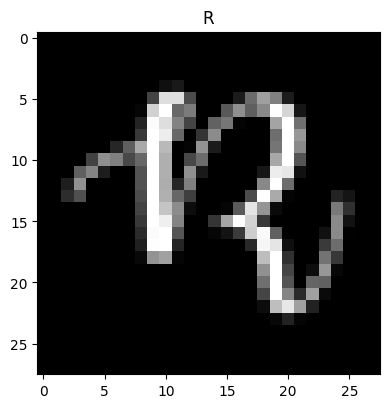

In [106]:
symbol = "R"
font_path = os.path.join(BASE_PATH, list_of_fonts[0])
img = generate_symbol(symbol, font_path, ratio=0.8, image_size=(28, 28))
print_image(img, symbol)